In [11]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import RidgeCV, LassoCV, Lasso
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate


Load the data and divide it into training and test data

In [3]:
data = pd.read_csv('traindata.csv')
data = data.drop(['id','price','date', 'price/sqft', 'rootprice/sqft'], axis=1)
X_train = data.drop(['log price'], axis=1)
y_train = data['log price']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Baseline models

Fit the data to Ridge regression

In [4]:
ridge = RidgeCV(alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 1])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_

new_alphas = [x*alpha for x in [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45]]

ridge_best = RidgeCV(alphas=new_alphas)
ridge_best.fit(X_train, y_train)
alpha_best = ridge_best.alpha_
print("best alpha: ", alpha_best)

y_pred_train = ridge_best.predict(X_train)
print("Train RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred = ridge_best.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: ", rmse_ridge)

best alpha:  0.255
Train RMSE:  0.2343906799030603
Test RMSE:  0.23838821658471995


Fit the data to Lasso regression

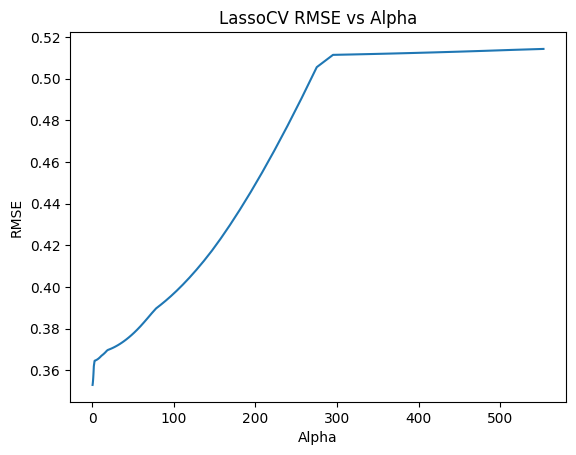

Best alpha: 0.5526859501877915
RMSE using best alpha: 0.3546325271642414


In [5]:
lasso = LassoCV(cv = 10)
lasso.fit(X_train, y_train)
rmse_lasso = np.sqrt(np.mean(lasso.mse_path_, axis=1))

plt.plot(lasso.alphas_, rmse_lasso)
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('LassoCV RMSE vs Alpha')
plt.show()

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE using best alpha:', rmse_lasso)

Fit the data to AdaBoost regression

In [6]:
model = AdaBoostRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model using mean squared error
rmse_adaboost = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean Squared Error: ", rmse_adaboost)

Mean Squared Error:  0.24839721794485817


Fit the data to Gradient boosting regression

In [7]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.0326094778538761


Seems like Gradient boosting is yielding the best results. Let's try to find the best parameters for this model

In [8]:
model_params = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [120],
    'learning_rate': [0.1],
    'max_depth': [7]
}

grid_search = GridSearchCV(estimator=model_params, param_grid=param_grid, cv=10)
grid_search.fit(X_train, y_train)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 120}
Best score:  0.9013680269996829


In [9]:
grid_search.cv_results_['mean_test_score']
y_pred = grid_search.best_estimator_.predict(X_test)
rmse_gradient = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_gradient

0.16463179109729403

In [12]:
rmse_table = [['Rideg regression',rmse_ridge], ['Lasso regression', rmse_lasso], ['AdaBoost', rmse_adaboost], ['GradientBoost', rmse_gradient]]
print(tabulate(rmse_table, headers=['Model Name', "RMSE"], tablefmt="psql"))

+------------------+----------+
| Model Name       |     RMSE |
|------------------+----------|
| Rideg regression | 0.238388 |
| Lasso regression | 0.354633 |
| AdaBoost         | 0.248397 |
| GradientBoost    | 0.164632 |
+------------------+----------+


One can see that GradientBoost is performing the best. Let's look at the feature importances of the best performing estimators with the optimal parameters. 

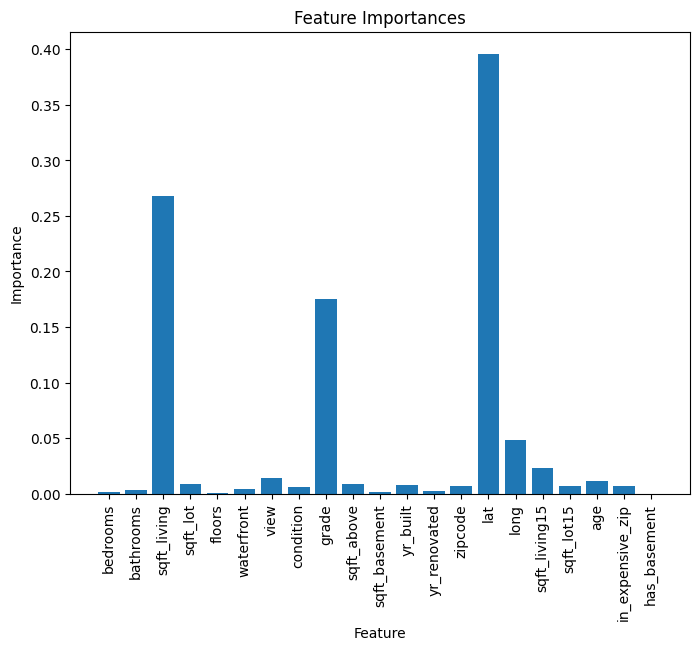

In [13]:
feature_importances  = grid_search.best_estimator_.feature_importances_
feature_names = list(X_train.columns)

feature_df = pd.DataFrame()
feature_df['importance'] = feature_importances
feature_df['feature'] = feature_names

plt.figure(figsize=(8, 6))
plt.bar(feature_df['feature'], feature_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

One can see that only a few of the features are significant predictors. Let's train a model by only selecting the top features.

In [130]:
X_train_importance = X_train[['sqft_living','view','grade','lat', 'long','age', 'in_expensive_zip']]
X_test_importance = X_test[['sqft_living','view','grade','lat', 'long','age', 'in_expensive_zip']]

grid_search_importance = GridSearchCV(estimator=model_params, param_grid=param_grid, cv=10)
grid_search_importance.fit(X_train_importance, y_train)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 120}
Best score:  0.9013780069285368


This model is doing fairly well with the training data only having a limited amount of features. Let's test on the held out test data.

In [133]:
y_pred_importance = grid_search_importance.best_estimator_.predict(X_test_importance)
rmse_gradient_importance = np.sqrt(mean_squared_error(y_test, y_pred_importance))
rmse_gradient_importance

0.17369702942428564

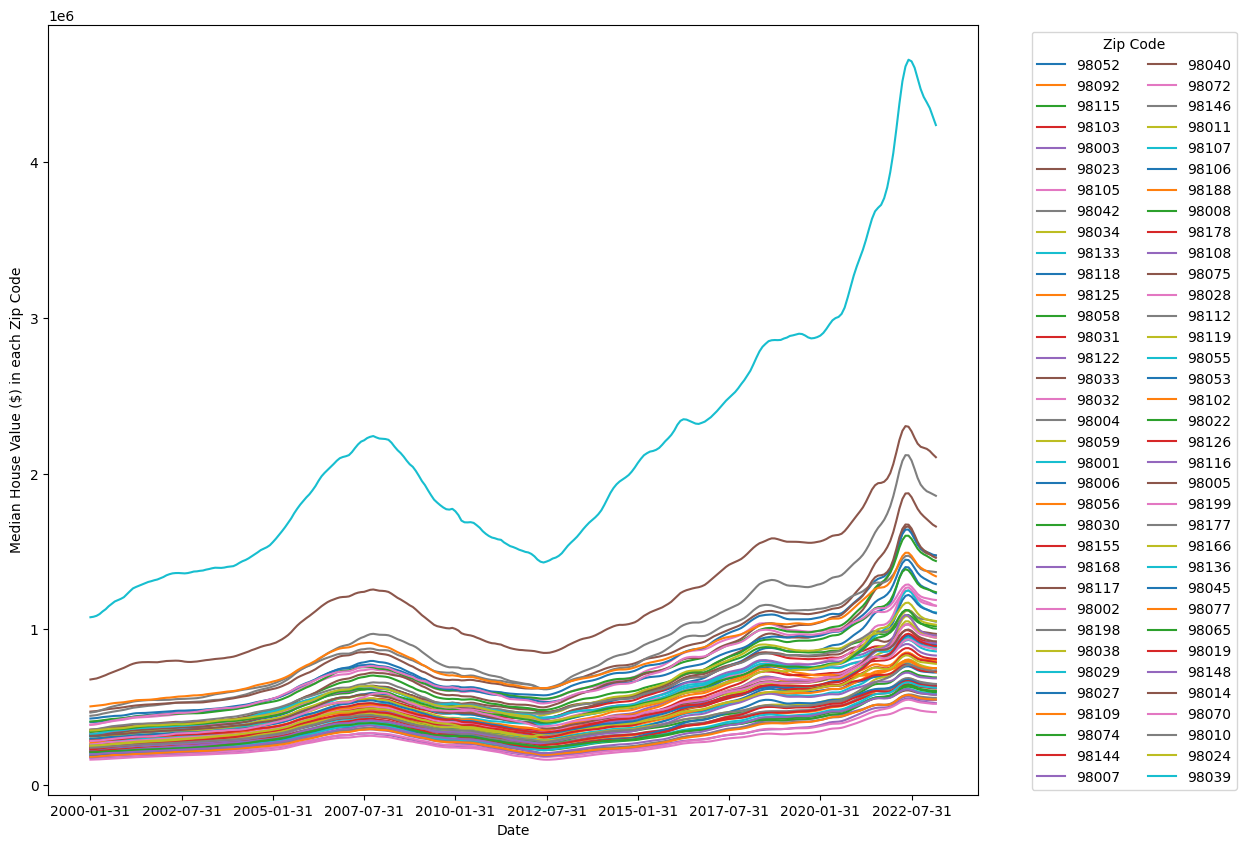

In [14]:
from matplotlib.ticker import MaxNLocator

king_zip = pd.read_csv("king_county_zip.csv")
zip_codes = king_zip["RegionName"].unique()

fig, ax = plt.subplots(figsize=(12, 10))
for zip_code in zip_codes:
    subset = king_zip[king_zip["RegionName"] == zip_code]
    ax.plot(subset.columns[2:], subset.iloc[:, 2:].values.flatten(), label=zip_code)
ax.legend(title="Zip Code", loc="upper left", bbox_to_anchor=(1.05, 1), ncol=2)
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(MaxNLocator(nbins=12, prune='both'))
ax.set_ylabel("Median House Value ($) in each Zip Code")
plt.show()

zip_diff_dict = {}
start_date = '2015-01-31'
end_date = '2023-03-31'

for zip_code in zip_codes:
    row = king_zip.loc[king_zip['RegionName'] == zip_code]
    first_price = row.iloc[0]['2015-01-31']
    last_price = row.iloc[0]['2023-03-31']
    price_diff = last_price/first_price
    zip_diff_dict[zip_code] = price_diff


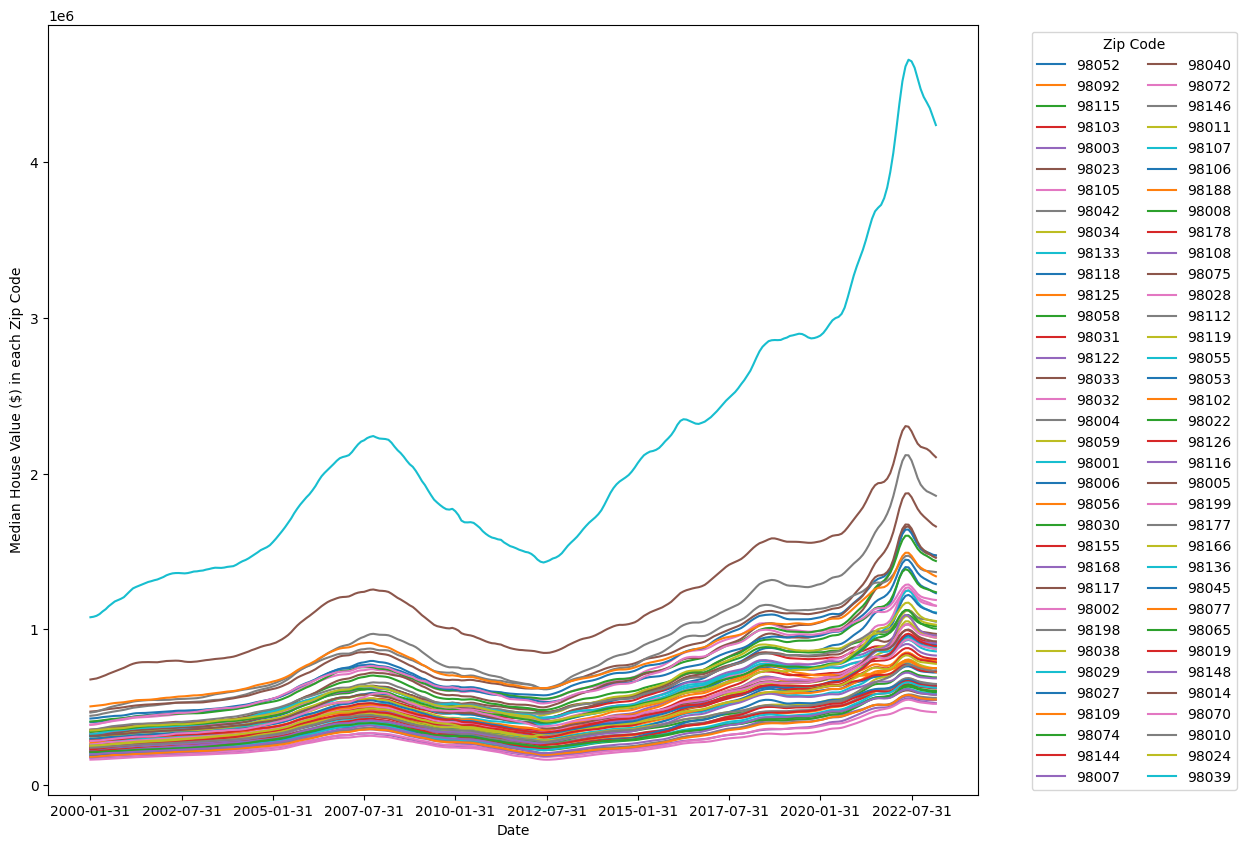

In [15]:
from matplotlib.ticker import MaxNLocator

king_zip = pd.read_csv("king_county_zip.csv")
zip_codes = king_zip["RegionName"].unique()

fig, ax = plt.subplots(figsize=(12, 10))
for zip_code in zip_codes:
    subset = king_zip[king_zip["RegionName"] == zip_code]
    ax.plot(subset.columns[2:], subset.iloc[:, 2:].values.flatten(), label=zip_code)
ax.legend(title="Zip Code", loc="upper left", bbox_to_anchor=(1.05, 1), ncol=2)
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(MaxNLocator(nbins=12, prune='both'))
ax.set_ylabel("Median House Value ($) in each Zip Code")
plt.show()

zip_diff_dict = {}
start_date = '2015-01-31'
end_date = '2023-03-31'

for zip_code in zip_codes:
    row = king_zip.loc[king_zip['RegionName'] == zip_code]
    first_price = row.iloc[0]['2015-01-31']
    last_price = row.iloc[0]['2023-03-31']
    price_diff = last_price/first_price
    zip_diff_dict[zip_code] = price_diff


# Predicting housing prices baswed on information from zwillow

In this part, we are looking for houses within zipcodes that our dataset includes. Then we find information about the house, add these values to a dataframe and use our model to predict the price of the house based on the information we have collected. Our dataset is from 2014, and it is important to note that housing prices in King county has increased by 103% since 2014. Hence, we need to multiply the predicted price by (1+103/100) = 2.03

# House 1

- https://www.zillow.com/homedetails/15538-NE-15th-Pl-301-Bellevue-WA-98007/2065445877_zpid/
- Price: 1,399,995$
- 1 719 sqft
- Does not have view towards lake
- Grade : 8
- latitude: 47.623370
- longitude: -122.333330
- age: 0
- not in expensive neighborhood

In [19]:
data_zwillow = {'sqft_living': [1719],'view':[0], 'grade': [8],'lat': [47.623370], 'long': [-122.133130], 'age': [0], 'in_expensive_zip': [0]}

zwillow_house = pd.DataFrame(data_zwillow)

log_price = grid_search_importance.best_estimator_.predict(zwillow_house)
price = np.exp(log_price)
price[0]*2.03

print("Predicted price: ", price[0]*2.03)
print("Difference from original price: ", 1399995-price[0]*2.03)

Predicted price:  1114505.8645910313
Difference from original price:  285489.13540896866


# House 2

- https://www.zillow.com/homedetails/156-140th-Pl-NE-118-Bellevue-WA-98007/49138747_zpid/
- Price: 1,139,000$
- 2 449 sqft
- Does not have view towards lake
- Grade : 7
- latitude: 47.6105643
- longitude: -122.1525164
- age: 50
- not in expensive neighborhood

In [20]:
data_zwillow2 = {'sqft_living': [2449],'view':[0], 'grade': [7],'lat': [47.6105643], 'long': [-122.1525164], 'age': [50], 'in_expensive_zip': [0]}

# create a new DataFrame from the dictionary
zwillow_house2 = pd.DataFrame(data_zwillow2)

# display the new DataFrame

log_price2 = grid_search_importance.best_estimator_.predict(zwillow_house2)
price2 = np.exp(log_price2)
price2[0]*2.03

print("Predicted price: ", price2[0]*2.03)
print("Difference from original price: ", price2[0]*2.03-1139000)

Predicted price:  1214891.6589389546
Difference from original price:  75891.65893895458


# House 3

- https://www.zillow.com/homedetails/156-140th-Pl-NE-118-Bellevue-WA-98007/49138747_zpid/
- Price: 1,139,000$
- 2 449 sqft
- Does not have view towards lake
- Grade : 7
- latitude: 47.6105643
- longitude: -122.1525164
- age: 50
- not in expensive neighborhood

In [21]:
data_house3 = {'sqft_living': [1287],
        'view': [1], 'grade': [8], 'lat': [47.617320], 'long': [-122.238450], 'age': [72], 'in_expensive_zip': [1]}

# create a new DataFrame from the dictionary
zwillow_house3 = pd.DataFrame(data_house3)
log_price_house3 = grid_search_importance.best_estimator_.predict(zwillow_house3)
price3 = np.exp(log_price_house3)
price3[0]*2.03
print("Predicted price: ", price3[0]*2.03)
print("Difference from original price: ", price3[0]*2.03-1139000)

Predicted price:  2022649.358206928
Difference from original price:  883649.358206928
